### Import Libraries

In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
import random

### Seed Everthing for Reproducibility

In [2]:
def seed_everything(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

seed_everything(0)

### Model

In [3]:
class Net(nn.Module):
    '''
    Defining model.
    1. Try to use minimal number of convolutions, with less channels, in accordance with RF required
    2. Used Transition layer with MaxPool and Pointwise convolution
    3. Used GAP layer, instead of linear to get data to 1D. THEN used a fully connected
    4. Added BN, Dropout(10%), Augmentations - RandomAffine
    '''
    def __init__(self):
        super(Net, self).__init__()

        # convolution block 1        
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(1, 8, 3),
            nn.ReLU(),
            nn.BatchNorm2d(8),
            nn.Dropout(0.10),

            nn.Conv2d(8, 16, 3),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(0.10)
        )

        # convolution block 2
        self.conv_block_2 = nn.Sequential(

            nn.Conv2d(16, 32, 3),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Dropout(0.10)

        )

        # transition block 1
        self.transition_1 = nn.Sequential(
            nn.Conv2d(in_channels= 32,out_channels= 16, kernel_size =1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        
        # convolution block 3
        self.conv_block_3 = nn.Sequential(
            nn.Conv2d(16, 16, 3),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(0.10), 

            nn.Conv2d(16, 32, 3),
            nn.ReLU(),            
            nn.BatchNorm2d(32),
            nn.Dropout(0.10)
        )
        # fully connected
        self.fc1 = nn.Linear(32,10)


    def forward(self, x):

        x = self.conv_block_1(x)
        x = self.conv_block_2(x)
        x = self.transition_1(x)
        x = self.conv_block_3(x)
 
        # GAP 
        x = F.adaptive_avg_pool2d(x, (1, 1))  # Input - 7x7x32 -> Output - 1x1x32

        # reshape using flatten
        x = torch.flatten(x, 1)

        # Fully connected layer
        x = self.fc1(x) # 1x1x32 -> 1x1x10

        x = x.view(-1, 10)

        return F.log_softmax(x)

### Input Shape, Output Shape and RF

```
-------------------------------------------------------------------------------------------------------
        Layer (type)               Output Shape         Param         Input      Output      LRF     GRF
=======================================================================================================
            Conv2d-1            [-1, 8, 26, 26]              80     28x28x1     26x26x8    3x3      3x3
              ReLU-2            [-1, 8, 26, 26]               0    
       BatchNorm2d-3            [-1, 8, 26, 26]              16
           Dropout-4            [-1, 8, 26, 26]               0     
            Conv2d-5           [-1, 16, 24, 24]           1,168     26x26x8     24x24x16   3x3      5x5
              ReLU-6           [-1, 16, 24, 24]               0
       BatchNorm2d-7           [-1, 16, 24, 24]              32
           Dropout-8           [-1, 16, 24, 24]               0
            Conv2d-9           [-1, 32, 22, 22]           4,640     24x24x16    22x22x32   3x3      7x7
             ReLU-10           [-1, 32, 22, 22]               0
      BatchNorm2d-11           [-1, 32, 22, 22]              64
          Dropout-12           [-1, 32, 22, 22]               0
           Conv2d-13           [-1, 16, 22, 22]             528    22x22x32    22x22x16    3x3      7x7
             ReLU-14           [-1, 16, 22, 22]               0
        MaxPool2d-15           [-1, 16, 11, 11]               0                                     14x14
           Conv2d-16             [-1, 16, 9, 9]           2,320    11x11x16    9x9x16      3x3      16x16
             ReLU-17             [-1, 16, 9, 9]               0
      BatchNorm2d-18             [-1, 16, 9, 9]              32
          Dropout-19             [-1, 16, 9, 9]               0
           Conv2d-20             [-1, 32, 7, 7]           4,640    9x9x16      7x7x32      3x3     18x18
             ReLU-21             [-1, 32, 7, 7]               0
```

### Model Summary

In [4]:
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              80
              ReLU-2            [-1, 8, 26, 26]               0
       BatchNorm2d-3            [-1, 8, 26, 26]              16
           Dropout-4            [-1, 8, 26, 26]               0
            Conv2d-5           [-1, 16, 24, 24]           1,168
              ReLU-6           [-1, 16, 24, 24]               0
       BatchNorm2d-7           [-1, 16, 24, 24]              32
           Dropout-8           [-1, 16, 24, 24]               0
            Conv2d-9           [-1, 32, 22, 22]           4,640
             ReLU-10           [-1, 32, 22, 22]               0
      BatchNorm2d-11           [-1, 32, 22, 22]              64
          Dropout-12           [-1, 32, 22, 22]               0
           Conv2d-13           [-1, 16, 22, 22]             528
             ReLU-14           [-1, 16,

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:77: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


### Train and Test Dataset

In [5]:
batch_size = 128

kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}

train_dataset = datasets.MNIST('./data', train=True, download=True,
                    transform=transforms.Compose([
                        transforms.RandomAffine(degrees=10, translate=(0.1,0.1), scale=(0.9, 1.1)),
                        # transforms.RandomCrop(28 , padding = 1),
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ]))

test_dataset = datasets.MNIST('./data', train=False, transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ]))

### Train and Test DataLoaders

In [6]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True, **kwargs)

### Sample Data

Label: 5


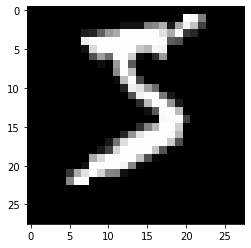

In [7]:
def show_sample(img, target):
    plt.imshow(torch.squeeze(img, axis=0), cmap='gray')
    print('Label:', target)

show_sample(*train_dataset[0])

### Batch Data

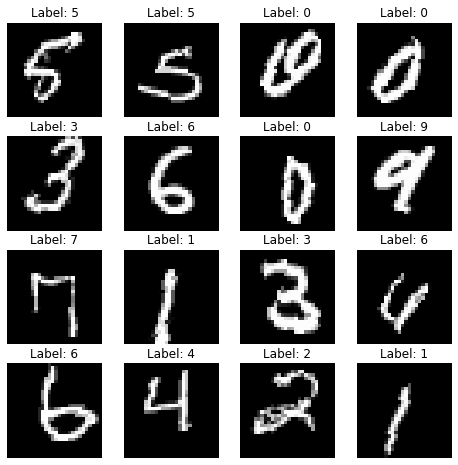

In [8]:
def show_batch(dl):
    images, labels = next(iter(dl))
    plt.figure(figsize=(8, 8))
    for i in range(16):
        ax = plt.subplot(4, 4, i + 1)
        ax.imshow(torch.squeeze(images[i], axis=0), cmap='gray')
        plt.title(f'Label: {labels[i].item()}')
        plt.axis('off')

show_batch(train_loader)

### Train and Test Statistics

In [9]:
def data_stats(dataset, train=True):
    train_data = dataset.data

    print('[Train]' if train else '[Test]')
    print(' - Numpy Shape:', train_data.cpu().numpy().shape)
    print(' - Tensor Shape:', train_data.size())
    print(' - min:', torch.min(train_data))
    print(' - max:', torch.max(train_data))
    print(' - mean:', train_data.cpu().numpy().mean())
    print(' - std:', train_data.cpu().numpy().std())
    print(' - var:', train_data.cpu().numpy().var())

data_stats(train_dataset)
print('\n')
data_stats(test_dataset, train=False)

[Train]
 - Numpy Shape: (60000, 28, 28)
 - Tensor Shape: torch.Size([60000, 28, 28])
 - min: tensor(0, dtype=torch.uint8)
 - max: tensor(255, dtype=torch.uint8)
 - mean: 33.318421449829934
 - std: 78.56748998339798
 - var: 6172.850482291342


[Test]
 - Numpy Shape: (10000, 28, 28)
 - Tensor Shape: torch.Size([10000, 28, 28])
 - min: tensor(0, dtype=torch.uint8)
 - max: tensor(255, dtype=torch.uint8)
 - mean: 33.791224489795916
 - std: 79.17246322228644
 - var: 6268.278932684298


### Train and Test Loops

In [7]:
from tqdm import tqdm
def train(model, device, train_loader, optimizer, epoch):
    correct = 0
    model.train()
    pbar = tqdm(train_loader)
    per_batch_loss = []

    for batch_idx, (data, target) in enumerate(pbar):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)

        pred = output.argmax(dim=1, keepdim=True)          
        correct += pred.eq(target.view_as(pred)).sum().item()

        loss = F.nll_loss(output, target)
        per_batch_loss.append(loss.item())
        loss.backward()
        optimizer.step()

        pbar.set_description(desc= f'epoch={epoch} Loss={loss.item()} batch_id={batch_idx:05d}')
    
    per_epoch_loss = sum(per_batch_loss)/len(per_batch_loss)
    per_epoch_accuracy = 100.*( correct / len(train_loader.dataset))
    
    return per_epoch_loss, per_epoch_accuracy

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
        

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))


    return test_loss , 100. * correct / len(test_loader.dataset)


### Model Training

In [8]:
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.018, momentum=0.9)
loss_train = []
accuracy_train = []
loss_test = []
accuracy_test = []
epochs = 19
for epoch in range(0, epochs):
    print('============== EPOCH ', epoch)
    loss_train_epoch,accuracy_train_epoch = train(model, device, train_loader, optimizer, epoch)
    loss_test_epoch, accuracy_test_epoch = test(model, device, test_loader)
    
    
    loss_train.append(loss_train_epoch)
    accuracy_train.append(accuracy_train_epoch)

    loss_test.append(loss_test_epoch)
    accuracy_test.append(accuracy_test_epoch)


  0%|          | 0/469 [00:00<?, ?it/s]

============== EPOCH  0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:77: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1428, Accuracy: 9560/10000 (95.60%)

============== EPOCH  1


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0440, Accuracy: 9880/10000 (98.80%)

============== EPOCH  2


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0438, Accuracy: 9881/10000 (98.81%)

============== EPOCH  3


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0371, Accuracy: 9896/10000 (98.96%)

============== EPOCH  4


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0339, Accuracy: 9893/10000 (98.93%)

============== EPOCH  5


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0269, Accuracy: 9920/10000 (99.20%)

============== EPOCH  6


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0245, Accuracy: 9925/10000 (99.25%)

============== EPOCH  7


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0290, Accuracy: 9916/10000 (99.16%)

============== EPOCH  8


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0246, Accuracy: 9926/10000 (99.26%)

============== EPOCH  9


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0241, Accuracy: 9921/10000 (99.21%)

============== EPOCH  10


epoch=10 Loss=0.018694132566452026 batch_id=00468: 100%|██████████| 469/469 [00:18<00:00, 25.73it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0201, Accuracy: 9939/10000 (99.39%)

============== EPOCH  11


epoch=11 Loss=0.015891270712018013 batch_id=00468: 100%|██████████| 469/469 [00:18<00:00, 25.93it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0212, Accuracy: 9937/10000 (99.37%)

============== EPOCH  12


epoch=12 Loss=0.020542984828352928 batch_id=00468: 100%|██████████| 469/469 [00:17<00:00, 26.22it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0210, Accuracy: 9937/10000 (99.37%)

============== EPOCH  13


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0193, Accuracy: 9944/10000 (99.44%)

============== EPOCH  14


epoch=14 Loss=0.013751081191003323 batch_id=00468: 100%|██████████| 469/469 [00:17<00:00, 26.43it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0196, Accuracy: 9935/10000 (99.35%)

============== EPOCH  15


epoch=15 Loss=0.060868799686431885 batch_id=00468: 100%|██████████| 469/469 [00:17<00:00, 26.24it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0201, Accuracy: 9936/10000 (99.36%)

============== EPOCH  16


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0225, Accuracy: 9934/10000 (99.34%)

============== EPOCH  17


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0188, Accuracy: 9944/10000 (99.44%)

============== EPOCH  18


epoch=18 Loss=0.026911074295639992 batch_id=00468: 100%|██████████| 469/469 [00:18<00:00, 25.59it/s]



Test set: Average loss: 0.0167, Accuracy: 9948/10000 (99.48%)



### Loss vs. No. of Epochs

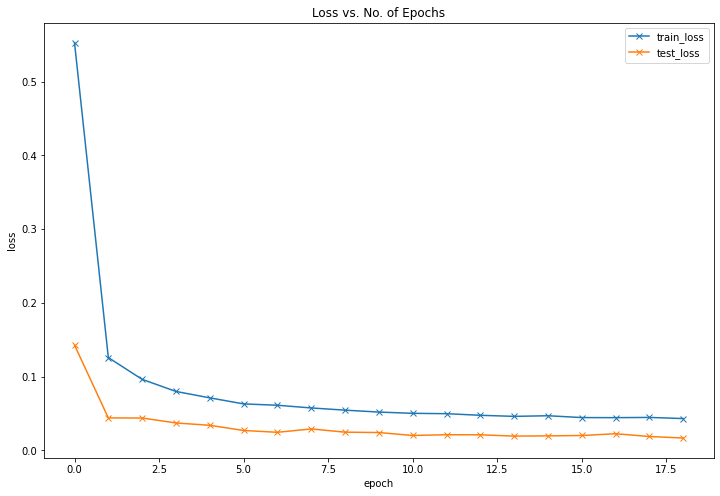

In [9]:
def plot_loss(train_loss, test_loss):
    plt.figure(figsize=(12, 8))
    plt.plot(loss_train,'-x')
    plt.plot(loss_test,'-x')
    plt.legend(['train_loss', 'test_loss'])
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.title('Loss vs. No. of Epochs')
    plt.savefig('Loss.png');

plot_loss(loss_train,loss_test)

### Accuracy vs. No. of Epochs

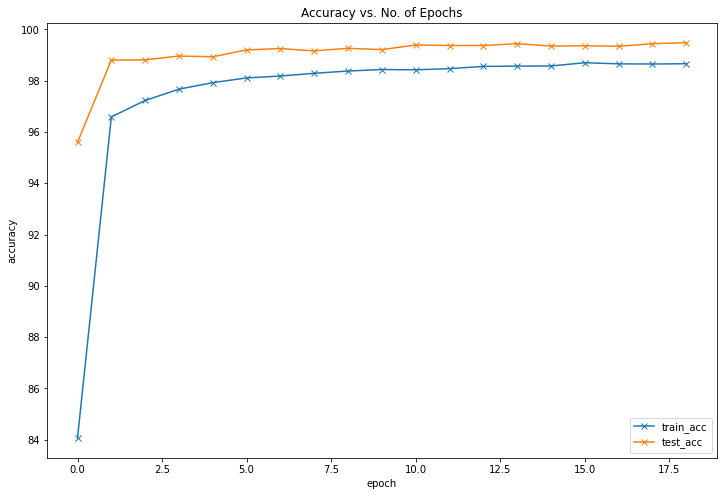

In [10]:
def plot_accuracy(train_acc, test_acc):
    plt.figure(figsize=(12, 8))
    plt.plot(train_acc,'-x')
    plt.plot(test_acc,'-x')
    plt.legend(['train_acc', 'test_acc'])
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of Epochs')
    plt.savefig('Accuracy.png');

plot_accuracy(accuracy_train,accuracy_test)